# ML Task

---
# Overview

This is a project where I build and train a model (classifier) to predict the target variable of a given anonymized dataset that contains a small set of features. 

**Goals of this Project:**

* Exploratory data analysis (EDA).
* Dataset engineering pipeline.
* Training and validation data splitting.
* Model selection, training, and evaluation.
* Results reporting and discussing.

---
# Dataset Exploration

Overall steps:
- create virtual environment
- explore data
- decide on the data format for training
- preprocess data
- split data to training and validation parts

In [1]:
# Code auto-formatting
%load_ext nb_black

<IPython.core.display.Javascript object>

## Necessary imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, f1_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import tensorflow.keras.backend as K

<IPython.core.display.Javascript object>

## Load and inspect the data

In [3]:
data_path = Path("data.csv").resolve()
data_df = pd.read_csv(data_path)

<IPython.core.display.Javascript object>

In [4]:
data_df.head()

,date,numeric0,numeric1,categorical0,time,target
0,2015-11-24,2515,2.0,c,01:33:52,0
1,2009-03-05,5156,NaN,b,20:09:27,0
2,2015-12-23,5930,NaN,b,11:22:35,0
3,1992-02-16,2967,NaN,b,19:18:36,0
4,1971-06-06,194,5.0,c,20:01:58,0


<IPython.core.display.Javascript object>

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          10000 non-null  object 
 1   numeric0      10000 non-null  int64  
 2   numeric1      5083 non-null   float64
 3   categorical0  10000 non-null  object 
 4   time          10000 non-null  object 
 5   target        10000 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 468.9+ KB


<IPython.core.display.Javascript object>

---
We have a lot of missing data for `numeric1` column, about 50%.

In [6]:
data_df.describe()

,numeric0,numeric1,target
count,10000.000000,5083.000000,10000.000000
mean,4981.998600,4.540035,0.133000
std,2886.313858,2.863159,0.339592
min,0.000000,0.000000,0.000000
25%,2499.750000,2.000000,0.000000
50%,4940.500000,5.000000,0.000000
75%,7487.250000,7.000000,0.000000
max,9999.000000,9.000000,1.000000


<IPython.core.display.Javascript object>

### Let's check target values

In [7]:
data_df.target.value_counts()

target
0    8670
1    1330
Name: count, dtype: int64

<IPython.core.display.Javascript object>

Here, we can see that the data is highly imbalanced. If we predicted `0` every time, we would end up with accuracy of 86.7%

### After a quick glance we can see these issues:
* Imbalanced data
* Missing values ('NaN's) 
* Mix of numerical and categorical data
* Date and timestamps (cyclic) data
* Possible scaling/normalizing of the data need

### Let's investigate further

In [8]:
data_df.categorical0.value_counts()

categorical0
b    3341
c    3335
a    3324
Name: count, dtype: int64

<IPython.core.display.Javascript object>

`categorical0` column has only three unique values evenly spread accross the dataset

In [9]:
data_df.numeric1.value_counts()

numeric1
2.0    541
8.0    527
6.0    526
9.0    525
4.0    522
5.0    516
3.0    490
0.0    484
1.0    484
7.0    468
Name: count, dtype: int64

<IPython.core.display.Javascript object>

The same (values almost uniformly spread accross the dataset) we can observe for `numeric1` column. Also, we can see that it looks like we have only 10 unique values. Previously, we have spotted about 50% of the data is missing. Based on these observations, we can think of two ways to approach the missing data issue:
- drop `numeric1` column (crude solution. not recommended)
- impute the data

<Axes: ylabel='Frequency'>

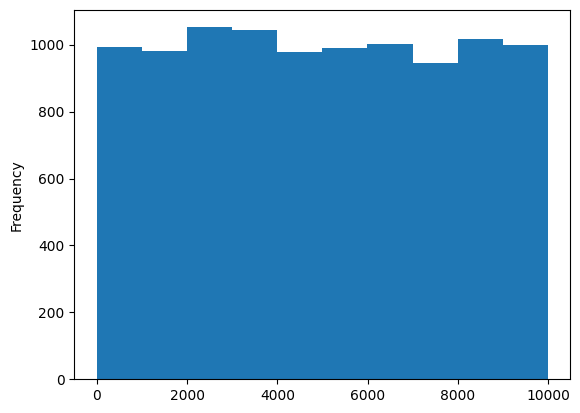

<IPython.core.display.Javascript object>

In [10]:
data_df.numeric0.plot.hist()

---
Now, let's try to group some values

In [11]:
data_df.groupby(["numeric1", "categorical0", "target"]).count()

date  numeric0  time
numeric1 categorical0 target                      
0.0      a            0        111       111   111
                      1         47        47    47
         b            0        161       161   161
                      1          4         4     4
         c            0        152       152   152
                      1          9         9     9
1.0      a            0        101       101   101
                      1         56        56    56
         b            0        163       163   163
                      1          3         3     3
         c            0        159       159   159
                      1          2         2     2
2.0      a            0        108       108   108
                      1         59        59    59
         b            0        180       180   180
                      1          8         8     8
         c            0        180       180   180
                      1          6         6     6
3.0      a            0        116       116   116
                      1         59        59    59
         b            0        140       140   140
                      1          3         3     3
         c            0        165       165   165
                      1          7         7     7
4.0      a            0        103       103   103
                      1         66        66    66
         b            0        164       164   164
                      1         11        11    11
         c            0        171       171   171
                      1          7         7     7
5.0      a            0        118       118   118
                      1         58        58    58
         b            0        164       164   164
                      1          5         5     5
         c            0        167       167   167
                      1          4         4     4
6.0      a            0        110       110   110
                      1         58        58    58
         b            0        170       170   170
                      1          5         5     5
         c            0        177       177   177
                      1          6         6     6
7.0      a            0        102       102   102
                      1         66        66    66
         b            0        154       154   154
                      1          2         2     2
         c            0        141       141   141
                      1          3         3     3
8.0      a            0        119       119   119
                      1         57        57    57
         b            0        181       181   181
                      1          4         4     4
         c            0        162       162   162
                      1          4         4     4
9.0      a            0        122       122   122
                      1         66        66    66
         b            0        170       170   170
                      1          7         7     7
         c            0        156       156   156
                      1          4         4     4

<IPython.core.display.Javascript object>

**Interesting.** Looks like category `a` is more likely to be classified as `1` than `b` or `c`

In [12]:
# Inspect `date` and `time` values
data_df.time.nunique(), data_df.date.nunique()

(9455, 7664)

<IPython.core.display.Javascript object>

In [13]:
sorted(data_df.date.values)[:5], sorted(data_df.date.values, reverse=True)[:5]

(['1970-01-01', '1970-01-02', '1970-01-05', '1970-01-06', '1970-01-06'],
 ['2019-08-24', '2019-08-22', '2019-08-18', '2019-08-18', '2019-08-18'])

<IPython.core.display.Javascript object>

Date starts from 1st Jan 1970 and ends on 24th Aug 2019

---

# Data preprocessing

In [14]:
data_df.head(10)

,date,numeric0,numeric1,categorical0,time,target
0,2015-11-24,2515,2.0,c,01:33:52,0
1,2009-03-05,5156,NaN,b,20:09:27,0
2,2015-12-23,5930,NaN,b,11:22:35,0
3,1992-02-16,2967,NaN,b,19:18:36,0
4,1971-06-06,194,5.0,c,20:01:58,0
5,2007-07-16,7792,9.0,b,01:01:44,0
6,2011-12-26,3399,NaN,b,06:17:32,0
7,1983-06-07,1139,NaN,c,16:12:01,0
8,2017-06-03,3069,NaN,b,01:10:32,0
9,2016-05-30,1002,7.0,b,01:30:26,0


<IPython.core.display.Javascript object>

--- 

First, let's deal with tme and data features. We have a few options:
- Slipt values to months, days, and hours
- Additionally, encode this cyclical data (for ex, for deep learning)

A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

Example of the problem with presenting cyclical data to a machine learning algorithm: there are discontinuities in the graph at the end of each day, when the hour value goes from  `23`  to  `00`.

In [16]:
data_df_modified = data_df.copy()

<IPython.core.display.Javascript object>

In [17]:
# Let's encode
def encode(data_df: pd.DataFrame, column: str, max_val: int) -> pd.DataFrame:
    data_df[f"{column}_sin"] = np.sin(2 * np.pi * data_df[column] / max_val)
    data_df[f"{column}_cos"] = np.cos(2 * np.pi * data_df[column] / max_val)
    return data_df


# Combine date and time so we have one `datetime` column
data_df_modified["datetime"] = pd.to_datetime(
    data_df_modified[["date", "time"]].agg(" ".join, axis=1)
)

# Encode
cols_to_create = [("month", 12), ("day", 365), ("hour", 23)]
for column, max_val in cols_to_create:
    data_df_modified[column] = eval(f"data_df_modified.datetime.dt.{column}")
    data_df_modified = encode(data_df=data_df_modified, column=column, max_val=max_val)

data_df_modified.drop(columns=["date", "time", "datetime"], inplace=True)
data_df_modified.head()

,numeric0,numeric1,categorical0,target,month,month_sin,month_cos,day,day_sin,day_cos,hour,hour_sin,hour_cos
0,2515,2.0,c,0,11,-5.000000e-01,8.660254e-01,24,0.401488,0.915864,1,0.269797,0.962917
1,5156,NaN,b,0,3,1.000000e+00,6.123234e-17,5,0.085965,0.996298,20,-0.730836,0.682553
2,5930,NaN,b,0,12,-2.449294e-16,1.000000e+00,23,0.385663,0.922640,11,0.136167,-0.990686
3,2967,NaN,b,0,2,8.660254e-01,5.000000e-01,16,0.271958,0.962309,19,-0.887885,0.460065
4,194,5.0,c,0,6,1.224647e-16,-1.000000e+00,6,0.103102,0.994671,20,-0.730836,0.682553


<IPython.core.display.Javascript object>

In [18]:
# Label categorical
mapper = {"a": 1, "b": 2, "c": 3}

data_df_modified.categorical0 = data_df_modified.categorical0.map(mapper)
data_df_modified.head()

,numeric0,numeric1,categorical0,target,month,month_sin,month_cos,day,day_sin,day_cos,hour,hour_sin,hour_cos
0,2515,2.0,3,0,11,-5.000000e-01,8.660254e-01,24,0.401488,0.915864,1,0.269797,0.962917
1,5156,NaN,2,0,3,1.000000e+00,6.123234e-17,5,0.085965,0.996298,20,-0.730836,0.682553
2,5930,NaN,2,0,12,-2.449294e-16,1.000000e+00,23,0.385663,0.922640,11,0.136167,-0.990686
3,2967,NaN,2,0,2,8.660254e-01,5.000000e-01,16,0.271958,0.962309,19,-0.887885,0.460065
4,194,5.0,3,0,6,1.224647e-16,-1.000000e+00,6,0.103102,0.994671,20,-0.730836,0.682553


<IPython.core.display.Javascript object>

--- 

Next, let's impute missing data.

NOTE: To impute missing data different methods can be used. For example, impute based on correlations with other features or use algorithms like KNN or mean/median imputation.

Though I'm aware that random imputation for `numeric1` is not ideal as it introduces noise and may distort relationships between features, for the simplicity here I will use simple random assignment since we only have 10 unique values evenly spread across the dataset.


In [19]:
# Impute missing data
np.random.seed(12)  # seed for reproducibility

non_missing_values = data_df_modified["numeric1"].dropna()
min_val, max_val = non_missing_values.min(), non_missing_values.max()
data_df_modified["numeric1"] = data_df_modified["numeric1"].apply(
    lambda x: x if not pd.isna(x) else np.random.uniform(low=min_val, high=max_val)
).round()

data_df_modified.head(10)

,numeric0,numeric1,categorical0,target,month,month_sin,month_cos,day,day_sin,day_cos,hour,hour_sin,hour_cos
0,2515,2.0,3,0,11,-5.000000e-01,8.660254e-01,24,0.401488,0.915864,1,0.269797,0.962917
1,5156,1.0,2,0,3,1.000000e+00,6.123234e-17,5,0.085965,0.996298,20,-0.730836,0.682553
2,5930,7.0,2,0,12,-2.449294e-16,1.000000e+00,23,0.385663,0.922640,11,0.136167,-0.990686
3,2967,2.0,2,0,2,8.660254e-01,5.000000e-01,16,0.271958,0.962309,19,-0.887885,0.460065
4,194,5.0,3,0,6,1.224647e-16,-1.000000e+00,6,0.103102,0.994671,20,-0.730836,0.682553
5,7792,9.0,2,0,7,-5.000000e-01,-8.660254e-01,16,0.271958,0.962309,1,0.269797,0.962917
6,3399,5.0,2,0,12,-2.449294e-16,1.000000e+00,26,0.432776,0.901502,6,0.997669,-0.068242
7,1139,0.0,3,0,6,1.224647e-16,-1.000000e+00,7,0.120208,0.992749,16,-0.942261,-0.334880
8,3069,8.0,2,0,6,1.224647e-16,-1.000000e+00,3,0.051620,0.998667,1,0.269797,0.962917
9,1002,7.0,2,0,5,5.000000e-01,-8.660254e-01,30,0.493776,0.869589,1,0.269797,0.962917


<IPython.core.display.Javascript object>

<Axes: ylabel='Frequency'>

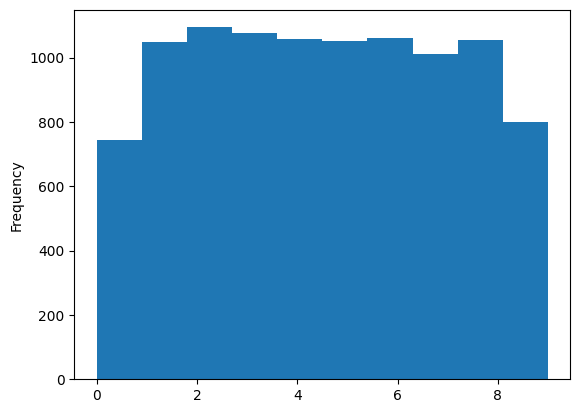

<IPython.core.display.Javascript object>

In [20]:
# Check that the distribution hasn't changed
data_df_modified.numeric1.plot.hist()

In [21]:
data_df_modified.dtypes

numeric0          int64
numeric1        float64
categorical0      int64
target            int64
month             int32
month_sin       float64
month_cos       float64
day               int32
day_sin         float64
day_cos         float64
hour              int32
hour_sin        float64
hour_cos        float64
dtype: object

<IPython.core.display.Javascript object>

# Model training

The data is highly imbalanced. If we predicted `0` every time, we would end up with accuracy of 86.7%.

To increase predictive capacity of the model the following methods are commonly used:
- Collecting more data to decrease imbalance
- Using other metrics (not accuracy) to measure model performance, for example F1-score
- Using less samples of the common class and/or more samples of the rare class for training
- Changing threshold for predicting the class
- Trying various algorithms
- Using weights to increase the importance of the rare class
- Generating artificial data

Random Forest is a great model to use in case of imbalanced data.

In [22]:
X = data_df_modified.drop(labels="target", axis=1)
X.drop(columns=["month", "day", "hour"], inplace=True)

y = data_df_modified.target.astype(int)

<IPython.core.display.Javascript object>

In [23]:
# Scale data
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X.copy())
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,numeric0,numeric1,categorical0,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,0.251525,0.222222,1.0,0.250000,0.933013,0.781908,0.395298,0.635214,9.813719e-01
1,0.515652,0.111111,0.5,1.000000,0.500000,0.139893,0.974414,0.133728,8.405339e-01
2,0.593059,0.777778,0.5,0.500000,1.000000,0.749709,0.444079,0.568242,5.551115e-17
3,0.296730,0.222222,0.5,0.933013,0.750000,0.518345,0.729696,0.055020,7.287694e-01
4,0.019402,0.555556,1.0,0.500000,0.000000,0.174762,0.962697,0.133728,8.405339e-01


<IPython.core.display.Javascript object>

In [24]:
# Evaluating feature importance
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X=X_scaled, y=y)
indices = np.argsort(clf.feature_importances_)[::-1]

print("Feature ranking:")
for f in range(X_scaled.shape[1]):
    name = X_scaled.columns[indices[f]]
    score = clf.feature_importances_[indices[f]]
    print(f"  feature {name:12}: ({score:.4f})")

Feature ranking:
  feature numeric0    : (0.3073)
  feature categorical0: (0.1907)
  feature numeric1    : (0.0851)
  feature day_sin     : (0.0808)
  feature day_cos     : (0.0798)
  feature hour_sin    : (0.0796)
  feature hour_cos    : (0.0674)
  feature month_sin   : (0.0551)
  feature month_cos   : (0.0541)


<IPython.core.display.Javascript object>

Only a couple of features have high importance. But we can't just throw away other features due to class imbalance, cause less important factors could be important for predicting `1`.

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, train_size=0.8, random_state=42, stratify=y
)
print(y_train.value_counts())
print(y_val.value_counts())

target
0    6936
1    1064
Name: count, dtype: int64
target
0    1734
1     266
Name: count, dtype: int64


<IPython.core.display.Javascript object>

In [26]:
clf = RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1,
    criterion="gini",
    max_features="sqrt",
    min_samples_split=100,
    max_depth=10,
    random_state=42,
)

calibrated_clf = CalibratedClassifierCV(estimator=clf, method="sigmoid", cv=5)
calibrated_clf.fit(X=X_train, y=y_train)

preds_proba_valid = calibrated_clf.predict_proba(X_val)
predictions_valid = calibrated_clf.predict(X_val)

<IPython.core.display.Javascript object>

In [27]:
# Define helper functions
def find_threshold(
    true_values: list, predictions_proba: list, plot_pr: bool = True
) -> tuple:
    precision, recall, thresholds = precision_recall_curve(
        y_true=true_values, y_score=predictions_proba
    )
    eps = np.finfo(float).eps  # to avoid division by `0`
    fscore = 2 * (precision * recall) / ((precision + recall) + eps)
    idx = np.argmax(fscore)
    best_thres = thresholds[idx]
    best_fscore = fscore[idx]
    print(f"Best threshold: {best_thres:.3f}, Best fscore: {best_fscore:.3f}")
    if plot_pr:
        plot(recall=recall, precision=precision)
    return best_thres


def plot(recall: list, precision: list) -> None:
    fig, ax = plt.subplots()
    ax.step(recall, precision, color="r", alpha=0.99, where="post", lw=1)
    ax.fill_between(recall, precision, alpha=0.2, color="b", step="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.show()

<IPython.core.display.Javascript object>

Best threshold: 0.208, Best fscore: 0.484


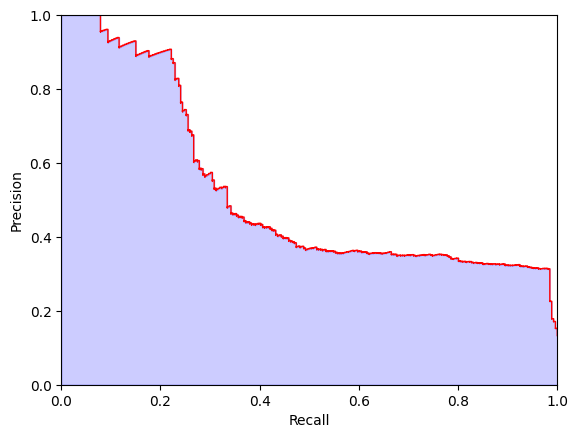

<IPython.core.display.Javascript object>

In [28]:
best_thres = find_threshold(
    true_values=y_val.values, predictions_proba=preds_proba_valid[:, 1], plot_pr=True
)

In [29]:
print(
    "Default behavior (the predicted class is the one with highest mean probability):\n"
)
print(
    classification_report(
        y_true=y_val,
        y_pred=pd.DataFrame(preds_proba_valid).idxmax(axis=1).values,
        target_names=["0", "1"],
        digits=4,
    )
)

Default behavior (the predicted class is the one with highest mean probability):

              precision    recall  f1-score   support

           0     0.8929    0.9954    0.9414      1734
           1     0.8806    0.2218    0.3544       266

    accuracy                         0.8925      2000
   macro avg     0.8868    0.6086    0.6479      2000
weighted avg     0.8913    0.8925    0.8633      2000



<IPython.core.display.Javascript object>

Assuming we have a case where both classes (`0` and `1`) are equally important, we can observe the result (f1-score): `0.6479`

---

In [30]:
print("If we choose the best threshold that maximizes F1-score:\n")
print(
    classification_report(
        y_true=y_val,
        y_pred=np.asarray(preds_proba_valid[:, 1] > best_thres, dtype=int),
        target_names=["0", "1"],
        digits=4,
    )
)

If we choose the best threshold that maximizes F1-score:

              precision    recall  f1-score   support

           0     0.9575    0.7797    0.8595      1734
           1     0.3503    0.7744    0.4824       266

    accuracy                         0.7790      2000
   macro avg     0.6539    0.7771    0.6710      2000
weighted avg     0.8768    0.7790    0.8094      2000



<IPython.core.display.Javascript object>

Using the adjusted threshold we can observe better result (f1-score): `0.6710`

Also, the higher recall for positive/rare class (with the cost of decreased precision)

## Let's try to train a neural network

Overall steps for developing a model:
- First, choose simple model
- Define dataset
- Try to overfit on a small part of dataset
- Tune hyperparameters, increase model complexity if needed
- Try to overfit on a larger part of dataset
- Use whole dataset for training
- Check inference

## Data preprocessing for deep learning

In [31]:
# Define class weights
neg, pos = np.bincount(np.asarray(y.values, dtype=np.int8))
total = neg + pos

weight_for_0 = (1 / neg) * (total) / 2.0
weight_for_1 = (1 / pos) * (total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: np.float64(0.5767012687427913), 1: np.float64(3.7593984962406015)}

<IPython.core.display.Javascript object>

## Training parameters

In [32]:
# Parameters for training
epochs = 20
batch_size = 16
learning_rate = 0.001
decay_steps = 5
lr_decay_rate = 0.7

<IPython.core.display.Javascript object>

## Build model

In [33]:
# Model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(512, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

# Helper function for a step decay
def scheduler(epoch):
    if epoch == 0:
        print("learning rate:", K.get_value(model.optimizer.learning_rate))
    # Decay lr
    if (epoch + 1) % decay_steps == 0:
        lr = K.get_value(model.optimizer.learning_rate)
        new_value = lr * lr_decay_rate
        model.optimizer.learning_rate.assign(new_value)
        print("learning rate:", K.get_value(model.optimizer.learning_rate))
    return K.get_value(model.optimizer.learning_rate)


# Define callbacks
learning_rate_decay = LearningRateScheduler(scheduler)
early_stop = EarlyStopping(monitor="val_loss", patience=20)

metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

# Model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=metrics,
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,569 (84.25 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

<IPython.core.display.Javascript object>

# Train

In [34]:
X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
X_val = X_val.to_numpy() if isinstance(X_val, pd.DataFrame) else X_val
y_val = y_val.to_numpy() if isinstance(y_val, pd.Series) else y_val

<IPython.core.display.Javascript object>

In [35]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    callbacks=[learning_rate_decay, early_stop],
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weight,
    verbose=1,
)

learning rate: 0.001
Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7816 - loss: 0.5261 - precision: 0.3226 - recall: 0.6693 - val_accuracy: 0.7095 - val_loss: 0.5097 - val_precision: 0.3048 - val_recall: 0.9248 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.7463 - loss: 0.4341 - precision: 0.3367 - recall: 0.9097 - val_accuracy: 0.6580 - val_loss: 0.5758 - val_precision: 0.2781 - val_recall: 0.9850 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.7408 - loss: 0.3949 - precision: 0.3344 - recall: 0.9505 - val_accuracy: 0.7265 - val_loss: 0.4793 - val_precision: 0.3201 - val_recall: 0.9398 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.7414 - loss: 0.3881 - precision: 0.3373 - recall: 0.9578 - val_accuracy: 0.7085 - val_loss: 0.3984 - val_precision: 0.3097 - val_recall: 0.9699 - learning_rate: 0.0010
learning rate: 0.00070000003
Epoch 5/

<IPython.core.display.Javascript object>

In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

<IPython.core.display.Javascript object>

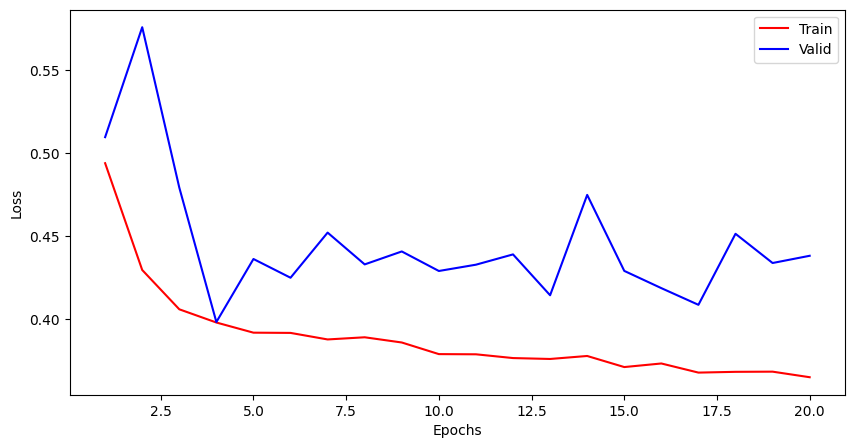

<IPython.core.display.Javascript object>

In [37]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs_plot = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_plot, loss_values, color="r", label="Train")
plt.plot(epochs_plot, val_loss_values, color="b", label="Valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [38]:
for k, v in model.evaluate(x=X_val, y=y_val, verbose=0, return_dict=True).items():
    print(f"validation {k:10}: {v:.3f}")

validation accuracy  : 0.711
validation loss      : 0.438
validation precision : 0.308
validation recall    : 0.947


<IPython.core.display.Javascript object>

# Check inference

In [39]:
X_val = pd.DataFrame(X_val)
y_val = pd.DataFrame(y_val)

<IPython.core.display.Javascript object>

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
Best threshold: 0.700, Best fscore: 0.498


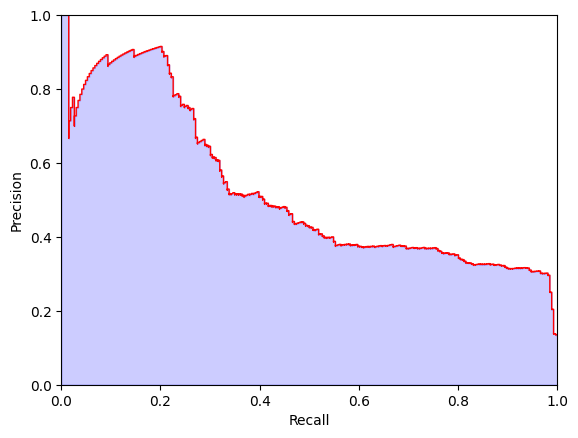

<IPython.core.display.Javascript object>

In [40]:
preds_proba_valid = model.predict(X_val)
preds_proba_valid = [p for p in preds_proba_valid]

best_thres = find_threshold(
    true_values=y_val.values, predictions_proba=preds_proba_valid, plot_pr=True
)

In [41]:
print("If we choose the best threshold that maximizes F1-score\n")
print(
    classification_report(
        y_true=y_val,
        y_pred=np.asarray(preds_proba_valid > best_thres, dtype=int),
        target_names=["0", "1"],
        digits=4,
    )
)

If we choose the best threshold that maximizes F1-score

              precision    recall  f1-score   support

           0     0.9548    0.8033    0.8725      1734
           1     0.3697    0.7519    0.4957       266

    accuracy                         0.7965      2000
   macro avg     0.6622    0.7776    0.6841      2000
weighted avg     0.8769    0.7965    0.8224      2000



<IPython.core.display.Javascript object>

## Reflection

The task was a two-part project. First, I needed to explore and prepare data for training. Second, I needed to develop and train a classification model.

With the data preprocess I needed to deal with different issues. It was hard to decide on some possible preprocessing steps without knowing the "bigger picture". However, the way to overall success was to carefully inspect the data and try a few modifications first. After that I could safely choose how to proceed further.

Having highly imbalanced data also presented some challenges. I needed to choose the metrics wisely. Since we have binary data, I decided to proceed with `f1-score` and `precision`/`recall` trade-off. Again, without knowing the business value it is hard to say what we should look at.

I chose to explore two different approaches - "random forest" classifier and a simple neural network. Seems like the classic way would be to use "random forest" with the data that was presented. However, it was interesting to check if we can have a better result using neural nets. In the end, the neural network performed on par the "random forest".

In order to get better results we might do the follow:
- Tune hyperparameters for both models (e.g. using grid or random search)
- Get more training data
- Experiment with oversampling (e.g., SMOTE) or undersampling alongside current techniques
- Introduce some data augmentations such as jitter and scaling
- Use different sampling techniques (sample rare class more frequently)
- Revisit missing value imputation with more context-aware methods
- Consider removing redundant features based on feature importance
- Use cross-validation to ensure the reported results are consistent across folds